# Brain Tumor Classification

`Name: Gangula Karthik`<br>
`Admin No: 223715Y`

**Objective:** The objective of this project is to develop an accurate and efficient image classifier for brain tumor detection and classification using deep learning techniques on MRI images.

This project aims to use a comprehensive dataset of 7,023 human brain MRI images in order to build an image classifier capable of detecting and categorizing brain tumors into four classes:

- glioma
- meningioma
- pituitary
- no tumor (healthy)

By using both from-scratch approach and fine-tuning techniques, the aim will be to create a robust model that can assist medical professionals in early detection and classification of brain tumors. This work is crucial in the field of medical imaging, as accurate and timely diagnosis can significantly impact treatment decisions and patient outcomes.

## Table of Contents

1. Importing Packages

## Importing Packages

In [2]:
# %pip install tensorflow==2.18.0 
# %pip install tensorflow-decision-forests==1.11.0
# %pip install tf-models-official==2.18.0

In [171]:
# Add imports here
import itertools
import pandas as pd
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import scipy.stats
import tensorflow as tf
import gc
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_models as tfm
from tensorflow import keras
from tensorflow.keras import layers
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
%matplotlib inline

sns.set_style("darkgrid", {"grid.color": ".6"})
warnings.filterwarnings('ignore')

In [5]:
!nvidia-smi

Sun Feb 23 01:13:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpu)
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


<div class="alert alert-info" role="alert">
    The code detects available GPUs and enables dynamic memory growth for each GPU to optimize memory usage during training.
</div>

## Downloading Dataset

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


<div class="alert alert-info" role="alert">

Dataset is downloaded through kagglehub. This package comes pre installed in google colab and kaggle notebooks. To install the package when needed, use: `pip install kagglehub`
</div>

## Loading the Dataset

In [8]:
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")

In [9]:
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append((img_path, label))
    return pd.DataFrame(data, columns=["file_path", "label"])

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [10]:
display("Train DataFrame:", train_df.head())
display("Test DataFrame:", test_df.head())

'Train DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

'Test DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

<div class="alert alert-info" role="alert">

The given dataset is in 4 folders corresponding to the respective label. Each folder contains multiple images. At the root level, there is the train and test folder. In order to understand this data better, the folder paths and the label has been parsed into a dataframe.
</div>

## Data Understanding

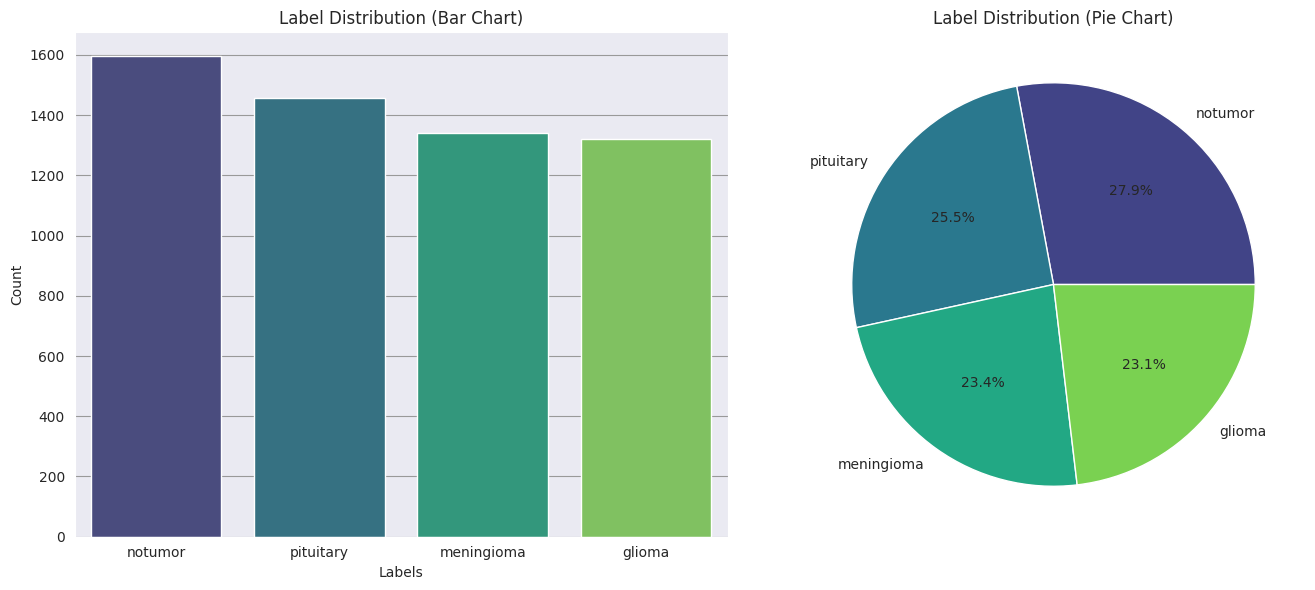

In [22]:
label_counts = train_df["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Label Distribution (Bar Chart)")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x")

axes[1].pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", colors=sns.color_palette("viridis", len(label_counts)))
axes[1].set_title("Label Distribution (Pie Chart)")

plt.tight_layout()
plt.show()

In [23]:
tqdm.pandas()

def get_image_size(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img.shape[1], img.shape[0]
    return None, None

train_df["width"], train_df["height"] = zip(*train_df["file_path"].progress_apply(get_image_size))
train_df["aspect_ratio"] = train_df["width"] / train_df["height"]
train_df[["width", "height", "aspect_ratio"]].describe()

100%|██████████| 5712/5712 [00:18<00:00, 300.75it/s]


width       height  aspect_ratio
count  5712.000000  5712.000000   5712.000000
mean    451.563200   453.883754      0.994201
std     131.004291   124.779164      0.109435
min     150.000000   168.000000      0.644809
25%     441.000000   442.000000      1.000000
50%     512.000000   512.000000      1.000000
75%     512.000000   512.000000      1.000000
max    1920.000000  1446.000000      1.785714

<div class="alert alert-info" role="alert">

- The image dimensions show a mean aspect ratio of approximately 1, with most images being close to square (441x442 to 512x512), but some images exhibit wider variations, with the max aspect ratio reaching 1.79, indicating a small proportion of non-square images.

- The width and height distributions have significant variability (std ~ 131 for width, ~ 125 for height), but the majority of images seem to be centered around 512x512 pixels, which could be indicative of standard resizing or cropping in preprocessing.
</div>

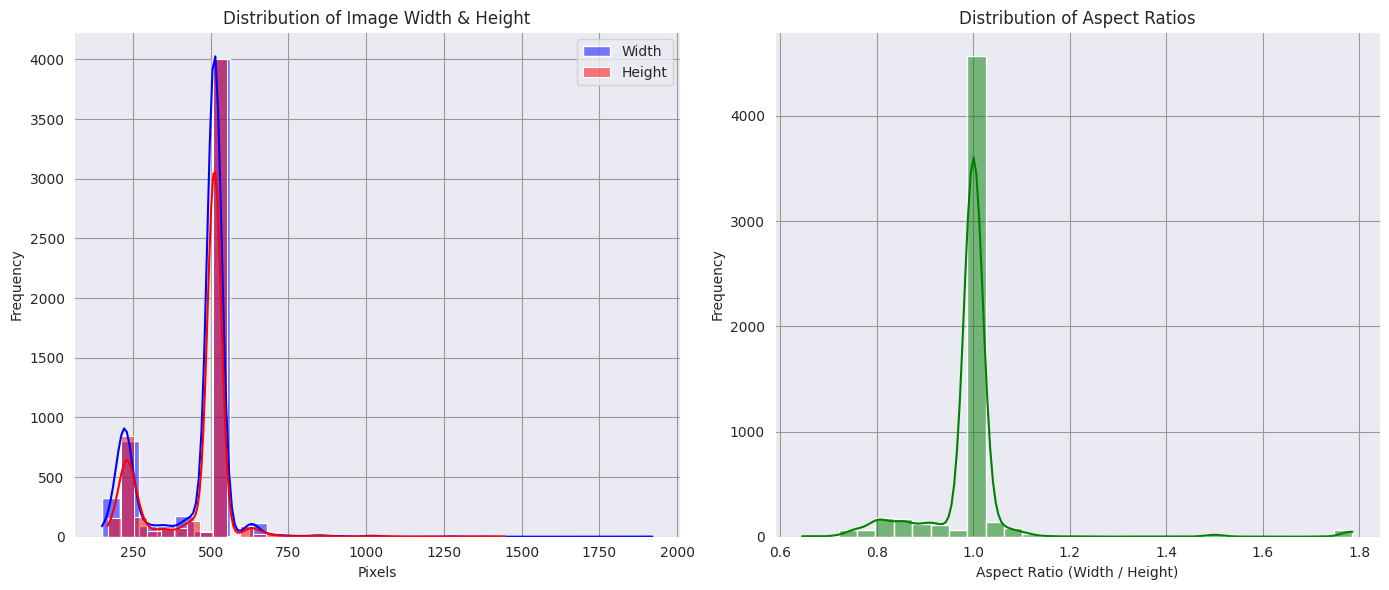

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram of the image sizes
sns.histplot(train_df["width"], bins=30, kde=True, ax=axes[0], color="blue", label="Width")
sns.histplot(train_df["height"], bins=30, kde=True, ax=axes[0], color="red", label="Height")
axes[0].set_title("Distribution of Image Width & Height")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# histogram of the aspect ratio
sns.histplot(train_df["aspect_ratio"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Aspect Ratios")
axes[1].set_xlabel("Aspect Ratio (Width / Height)")
axes[1].set_ylabel("Frequency")

# Show plots
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">

- The 2 charts further confirm what was observed looking at the summary statistics.
- A simple resize should not affect the aspect ratio of the images significantly.
</div>

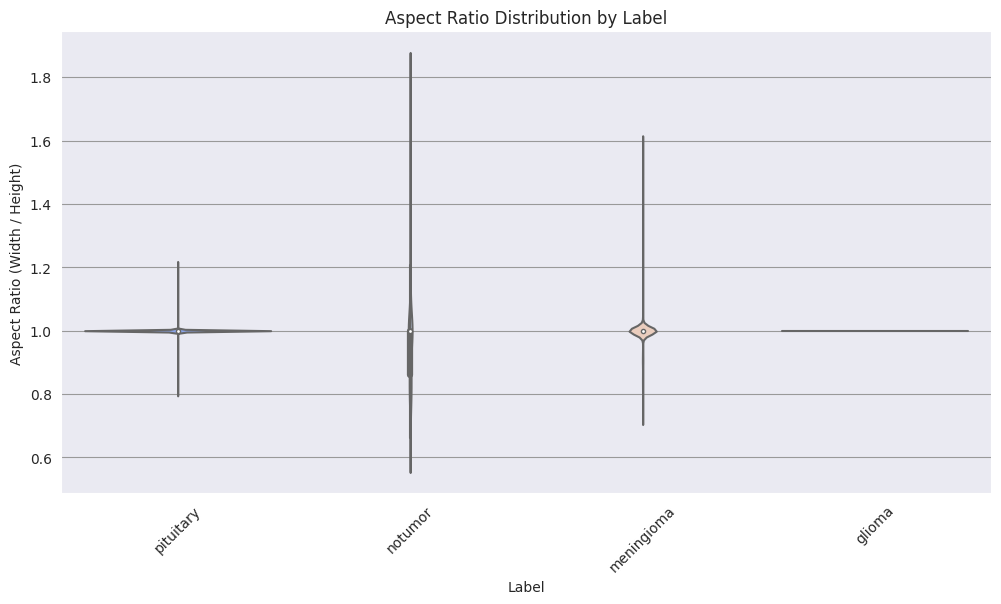

In [25]:
plt.figure(figsize=(12, 6))

sns.violinplot(x=train_df["label"], y=train_df["aspect_ratio"], palette="coolwarm")

plt.title("Aspect Ratio Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.xticks(rotation=45)

plt.show()

<div class="alert alert-info" role="alert">

- It can be seen that the notumor label tends to have a wider variability of the aspect ratio as compared to the other classes. All classes have a mean and median aspect ratio of around 1 which is good. It indicates that they are square in nature. 
</div>

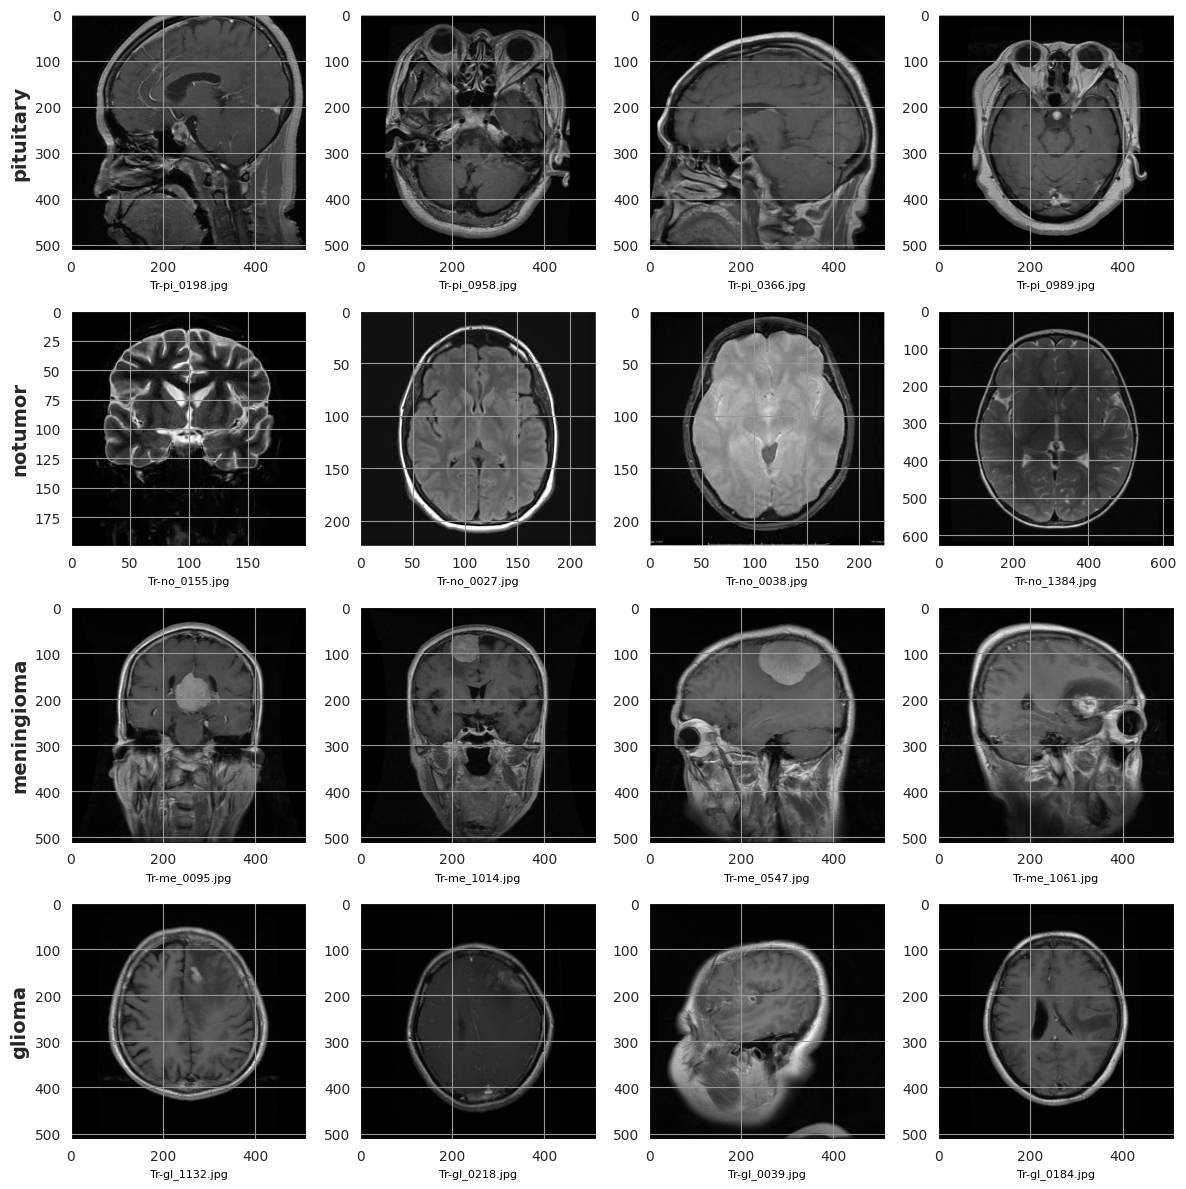

In [26]:
selected_labels = train_df["label"].unique()[:4]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for row, label in enumerate(selected_labels):
    sample_paths = random.sample(train_df[train_df["label"] == label]["file_path"].tolist(), 4)

    for col, sample_path in enumerate(sample_paths):
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axes[row, col]
        ax.imshow(img)

        if col == 0:
            ax.set_ylabel(label, fontsize=14, fontweight="bold")

        img_name = os.path.basename(sample_path)
        ax.set_xlabel(img_name, fontsize=8, color="black")

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">

- The different types of brain tumors can be seen in the grid above.
- From the first glance it can be seen that the tumors can be identified based on the shape (for meningioma it is circular white region) and region of the brain where its present.
- Due to lack of domain knowledge, will not be able to comment further.  
</div>

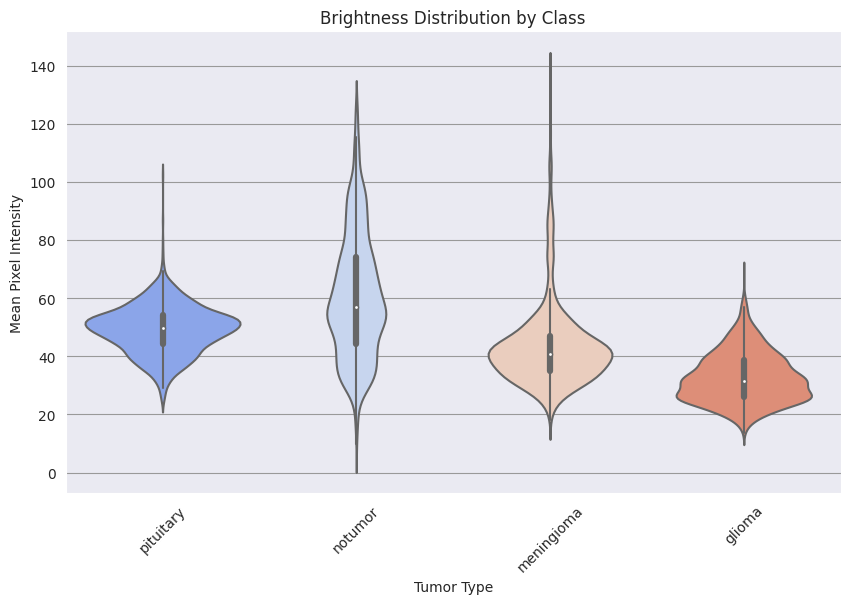

In [31]:
def compute_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img) if img is not None else None

train_df["brightness"] = train_df["file_path"].apply(compute_brightness)

plt.figure(figsize=(10, 6))
sns.violinplot(x=train_df["label"], y=train_df["brightness"], palette="coolwarm", split=True)
plt.title("Brightness Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Mean Pixel Intensity")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info" role="alert">

- The mean pixel intensity differs for each of the different classes, this suggests that it could be a useful factor in identifying the presence of the different tumor types.
- notumor and meningioma have the widest ranges while pituitary and glioma have the lowest.
</div>

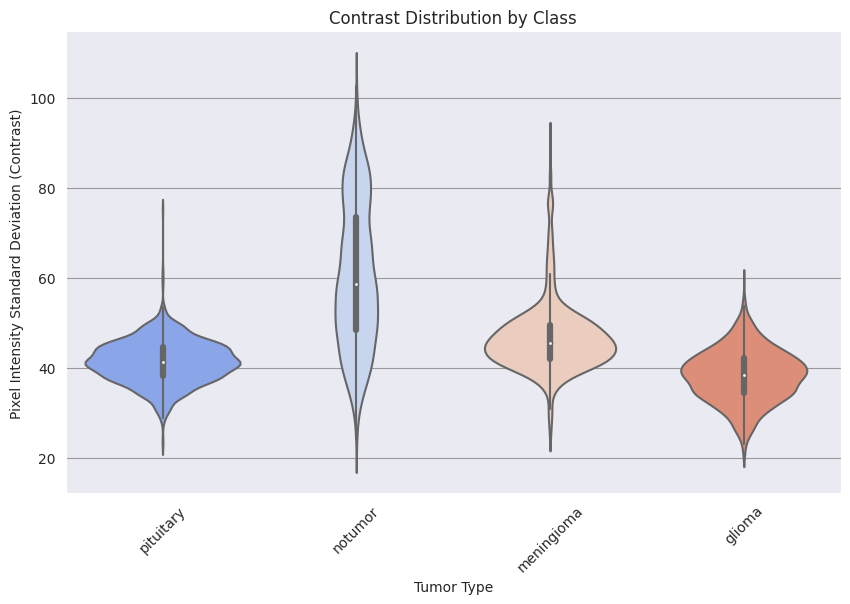

In [33]:
def compute_contrast(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(img) if img is not None else None

train_df["contrast"] = train_df["file_path"].apply(compute_contrast)

plt.figure(figsize=(10, 6))
sns.violinplot(x=train_df["label"], y=train_df["contrast"], palette="coolwarm")

plt.title("Contrast Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Pixel Intensity Standard Deviation (Contrast)")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info" role="alert">

- The standard deviation of the pixel intensity also shows the same characteristics as the previous chart. 
</div>

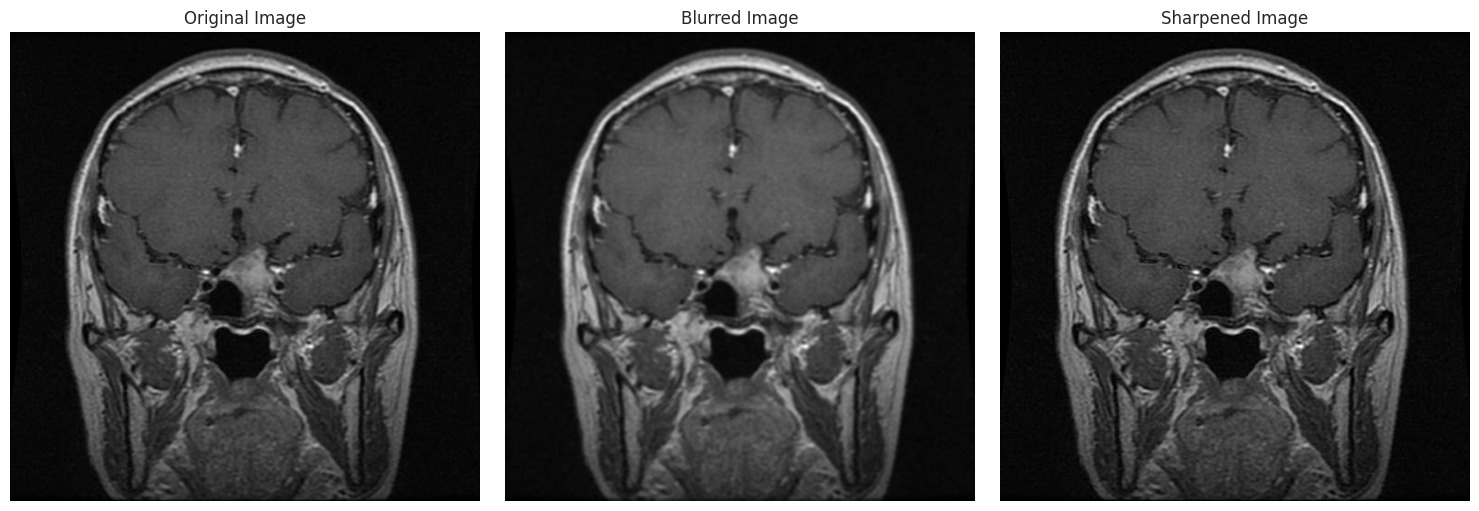

In [34]:
# image processing techniques

image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path)

# Convert to grayscale for easier processing
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Subtract the blurred image from the original (sharpening)
sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred Image")
axes[2].imshow(sharpened, cmap='gray')
axes[2].set_title("Sharpened Image")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">

- For the image preprocessing first step will be to sharpen the image to ensure that the features are easier to see and distinguish. 
</div>

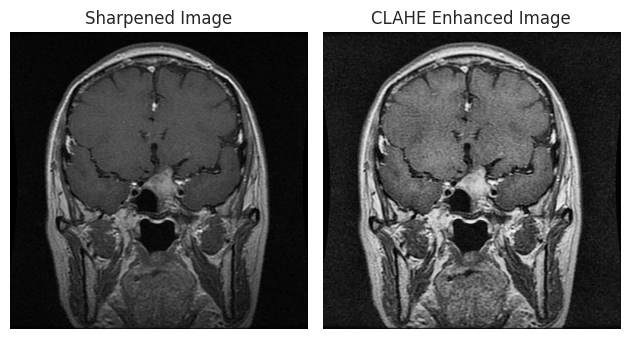

In [35]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(sharpened)

# Plot the results
plt.subplot(1, 2, 1)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_clahe, cmap='gray')
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">

- The second step is Contrast Limited Adaptive Histogram Equalization (CLAHE)
- CLAHE on brain MRI images enhances local contrast by improving the visibility of subtle structures, especially in regions with poor contrast, such as brain tissue near tumors or lesions, without amplifying noise. This method is crucial for better detecting abnormalities, aiding in more accurate diagnoses and analysis of fine details in medical imaging.
</div>

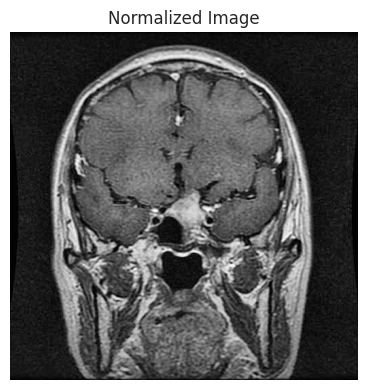

In [36]:
def z_score_normalization(mri_image):
    return (mri_image - np.mean(mri_image)) / np.std(mri_image)


normalized_img = z_score_normalization(img_clahe)

plt.figure(figsize=(12, 4))
plt.imshow(normalized_img, cmap='gray')
plt.title("Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">

- Normalization of MRI images is important because it adjusts the pixel intensity values to a consistent range, typically between 0 and 1, which helps standardize inputs for deep learning models. This ensures that the model is not biased towards certain intensity ranges, improving its performance and stability by allowing the network to learn more effectively, reducing sensitivity to variations in lighting, scanning protocols, or equipment.
</div>

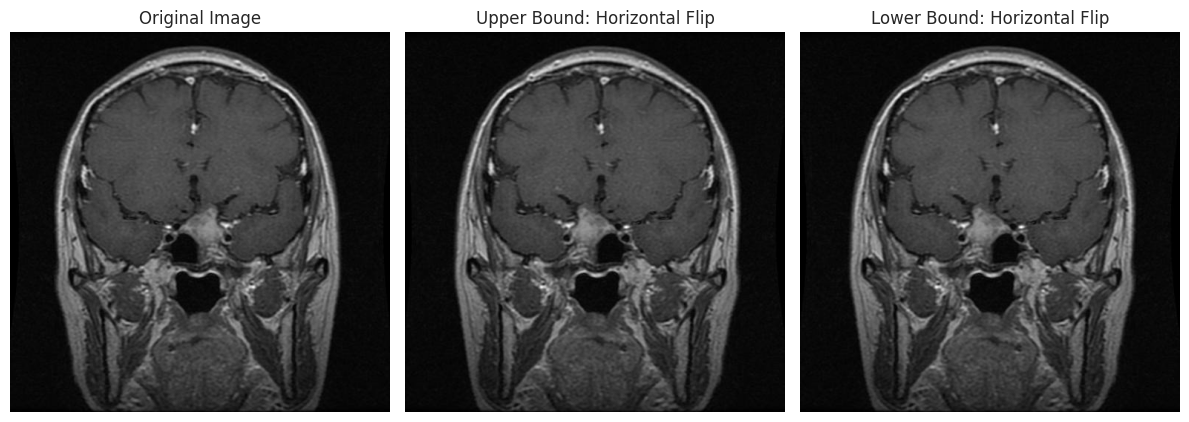

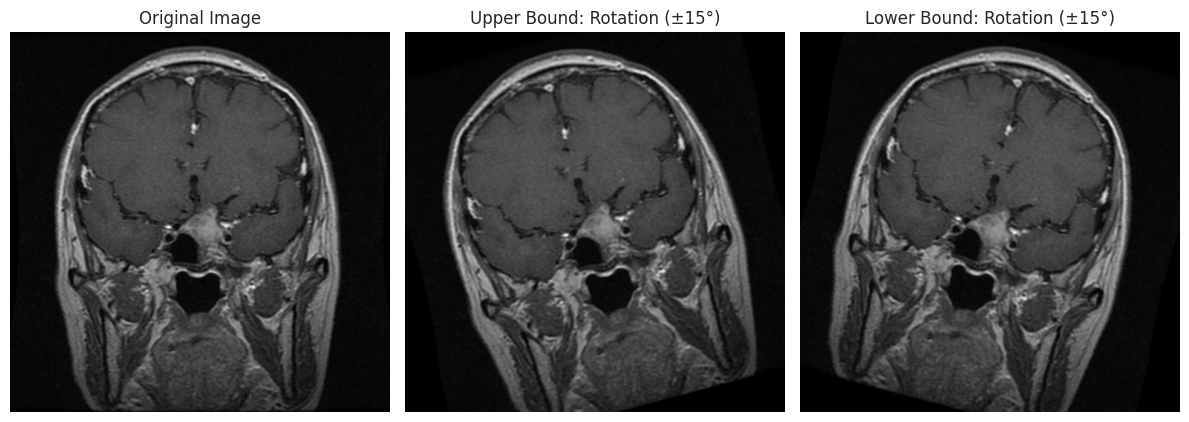

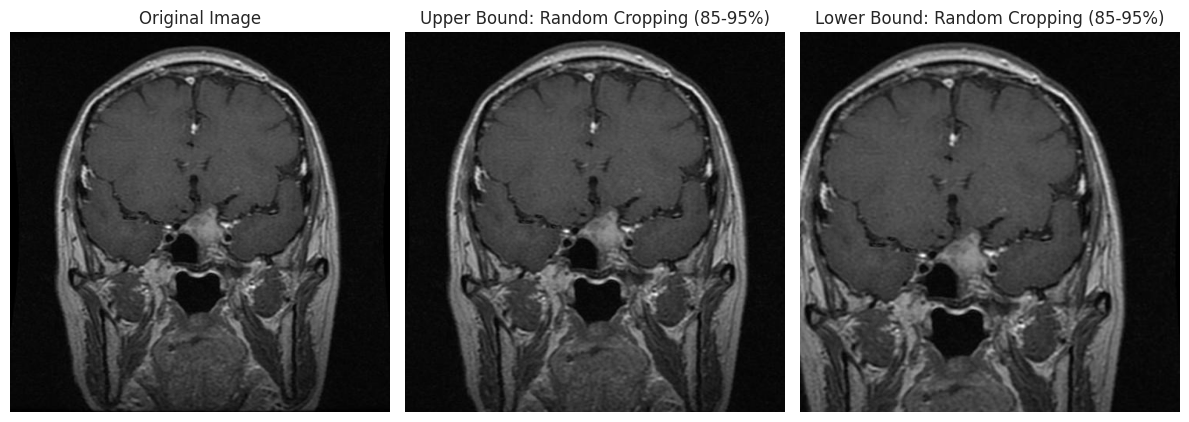

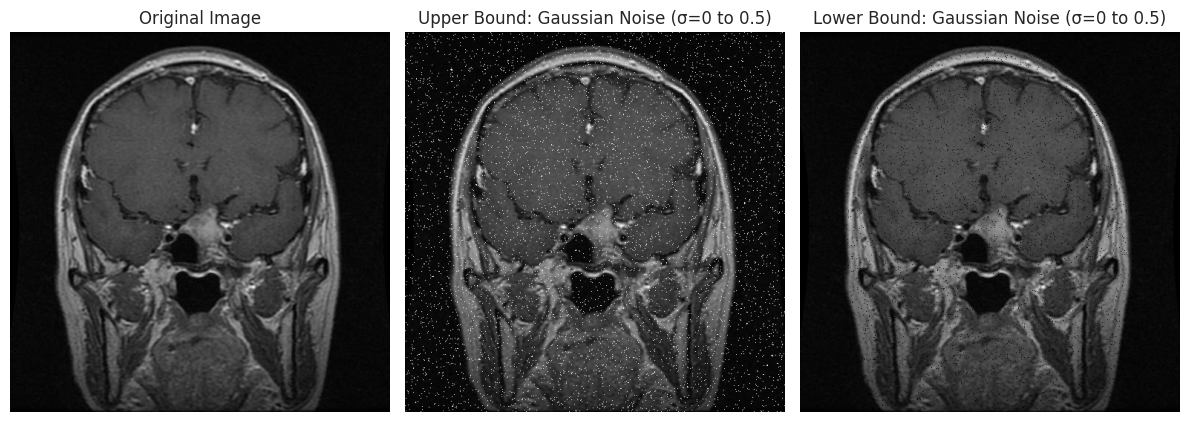

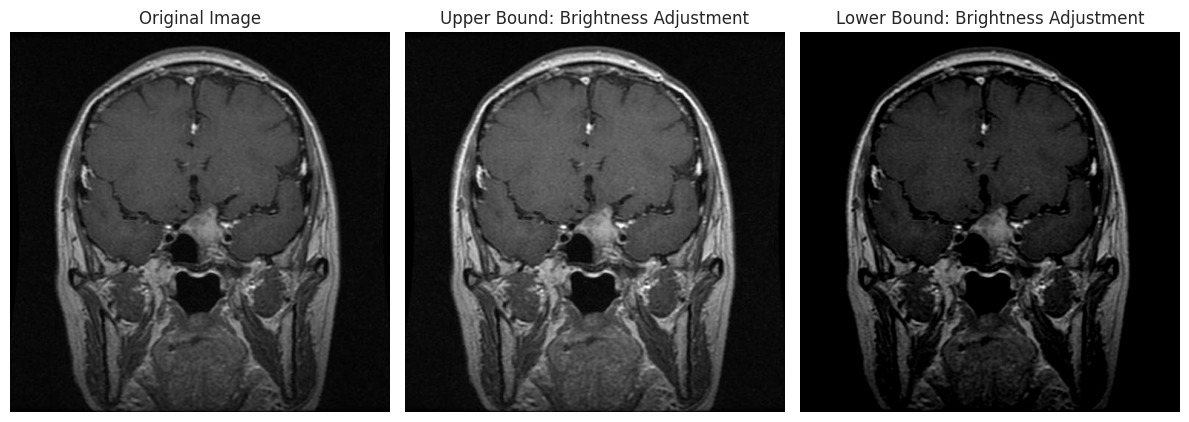

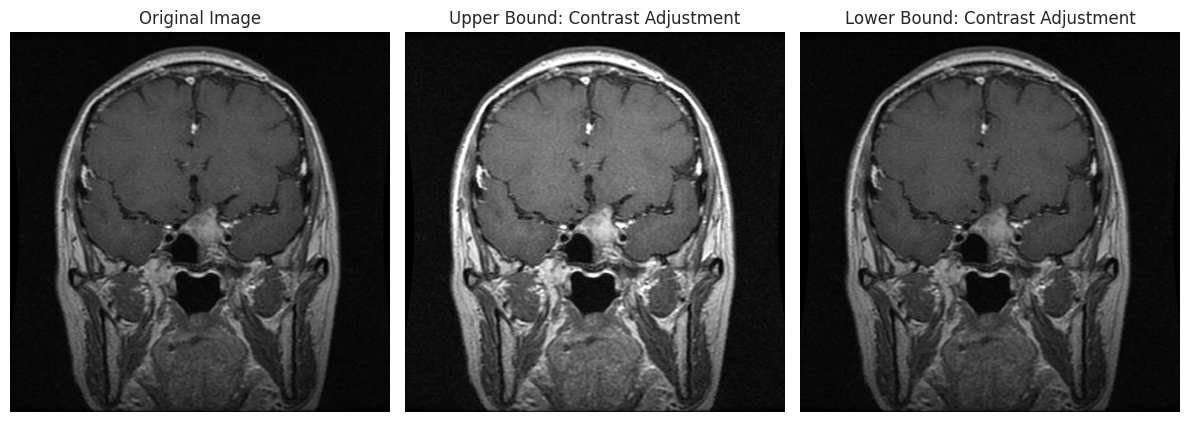

In [37]:
# Load MRI image
image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to visualize transformations
def visualize_transforms(original, upper, lower, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(upper, cmap='gray')
    plt.title(f"Upper Bound: {title}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(lower, cmap='gray')
    plt.title(f"Lower Bound: {title}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Apply transformations

# 1️⃣ Horizontal Flip
flipped = cv2.flip(img, 1)

# 2️⃣ Rotation (±15 degrees)
angle = 15
(h, w) = img.shape
center = (w // 2, h // 2)
M_rot_upper = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_upper = cv2.warpAffine(img, M_rot_upper, (w, h))

M_rot_lower = cv2.getRotationMatrix2D(center, -angle, 1.0)
rotated_lower = cv2.warpAffine(img, M_rot_lower, (w, h))

# 3️⃣ Random Cropping (85-95% ROI)
crop_size_upper = int(0.95 * img.shape[0])
crop_size_lower = int(0.85 * img.shape[0])
crop_x_upper = np.random.randint(0, img.shape[1] - crop_size_upper)
crop_y_upper = np.random.randint(0, img.shape[0] - crop_size_upper)
cropped_upper = img[crop_y_upper:crop_y_upper+crop_size_upper, crop_x_upper:crop_x_upper+crop_size_upper]

crop_x_lower = np.random.randint(0, img.shape[1] - crop_size_lower)
crop_y_lower = np.random.randint(0, img.shape[0] - crop_size_lower)
cropped_lower = img[crop_y_lower:crop_y_lower+crop_size_lower, crop_x_lower:crop_x_lower+crop_size_lower]

# 4️⃣ Gaussian Noise (σ=0.05)
noise = np.random.normal(0, 0.5, img.shape).astype(np.uint8)
gaussian_noisy_upper = cv2.add(img, noise)
gaussian_noisy_lower = cv2.subtract(img, noise)

# 5️⃣ Brightness Adjustment
bright_img_upper = cv2.add(img, 40)  # Brightness increase
bright_img_lower = cv2.subtract(img, 40)  # Brightness decrease

# 6️⃣ Contrast Adjustment
contrast_img_upper = cv2.convertScaleAbs(img, alpha=1.5, beta=0)  # Increase contrast
contrast_img_lower = cv2.convertScaleAbs(img, alpha=0.5, beta=0)  # Decrease contrast

# Visualize the transformations
visualize_transforms(img, flipped, flipped, "Horizontal Flip")
visualize_transforms(img, rotated_upper, rotated_lower, "Rotation (±15°)")
visualize_transforms(img, cropped_upper, cropped_lower, "Random Cropping (85-95%)")
visualize_transforms(img, gaussian_noisy_upper, gaussian_noisy_lower, "Gaussian Noise (σ=0 to 0.5)")
visualize_transforms(img, bright_img_upper, bright_img_lower, "Brightness Adjustment")
visualize_transforms(img, contrast_img_upper, contrast_img_lower, "Contrast Adjustment")

<div class="alert alert-info" role="alert">

- **Horizontal Flip**: Adds invariance to left-right orientation by mirroring the image.
- **Rotation (±15°)**: Provides rotational invariance to small variations in orientation.
- **Random Cropping (85-95%)**: Simulates zooming and ensures focus on different image regions.
- **Gaussian Noise (σ=0.5)**: Mimics sensor noise, improving robustness to imperfections.
- **Brightness Adjustment**: Simulates varying lighting conditions, enhancing model generalization.
- **Contrast Adjustment**: Emphasizes or softens structures, helping the model detect features under different contrast levels.
</div>

## Data Preparation

In [39]:
def preprocess_image(image_path):
    """Load and resize image to 256x256 using TensorFlow."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.image.per_image_standardization(img)
    return img

def process_tf_image(image_path, label, num_classes):
    """Load and preprocess an image while converting label to one-hot."""
    image = preprocess_image(image_path)
    label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
    return image, label

def load_and_preprocess_from_df(df, num_classes, batch_size=32):
    """Create a TensorFlow dataset from a DataFrame."""
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))
    dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(train_df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [40]:
train_dataset, _ = load_and_preprocess_from_df(train_df, 4)
train_dataset = train_dataset.shuffle(buffer_size=500).prefetch(tf.data.AUTOTUNE)

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

val_size = int(0.2 * len(train_dataset))

train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(AUTOTUNE)

<div class="alert alert-info" role="alert">

**Enhancements made for efficient data loading in tensorflow:**

- Efficient Data Pipeline: Using TensorFlow's tf.data API with parallel loading (`num_parallel_calls=tf.data.AUTOTUNE`) and prefetching optimizes data input, reducing I/O bottlenecks and speeding up training.
- Dynamic Batching and Shuffling: Automatic shuffling and batching of data, including on-the-fly label conversion to one-hot encoding, ensures better generalization and prevents model overfitting.
- Memory Efficiency: The use of `cache()` and `prefetch()` minimizes disk I/O and memory overhead during training, improving runtime performance and ensuring smooth data flow.
</div>

## Modelling (Training CNN model from scratch)

In [172]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # ✅ CNN Feature Extraction with Batch Normalization
    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


# Model compilation
model = build_model(input_shape=(128, 128, 3))
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_94 (ReLU)                      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_95 (ReLU)                      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_96 (ReLU)                      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_97 (ReLU)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,289,604 (16.36 MB)

 Trainable params: 4,288,900 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

<div class="alert alert-info" role="alert">

- **Convolutional Feature Extraction:** The simple model uses three convolutional layers (32, 64, 128 filters) with Batch Normalization and ReLU activation, followed by MaxPooling, to extract hierarchical features from the input image.
- **Fully Connected Classifier:** After flattening the features, a dense layer with 128 units, Batch Normalization, ReLU activation, and Dropout (0.3) is applied, leading to a final softmax output layer with 4 units for multi-class classification.
</div>

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.7186 - loss: 0.7871 - val_accuracy: 0.2214 - val_loss: 2.0925
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9033 - loss: 0.2743 - val_accuracy: 0.3562 - val_loss: 1.5766
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9688 - loss: 0.1358 - val_accuracy: 0.8848 - val_loss: 0.3254
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9910 - loss: 0.0665 - val_accuracy: 0.9830 - val_loss: 0.0838
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9958 - loss: 0.0349 - val_accuracy: 0.9821 - val_loss: 0.0591
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9986 - loss: 0.0237 - val_accuracy: 0.9821 - val_loss: 0.0578
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9996 - loss: 0.0163 - val_accuracy: 0.9812 - val_loss: 0.0512
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 0.0109 - val_acc

In [45]:
def plot_training_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

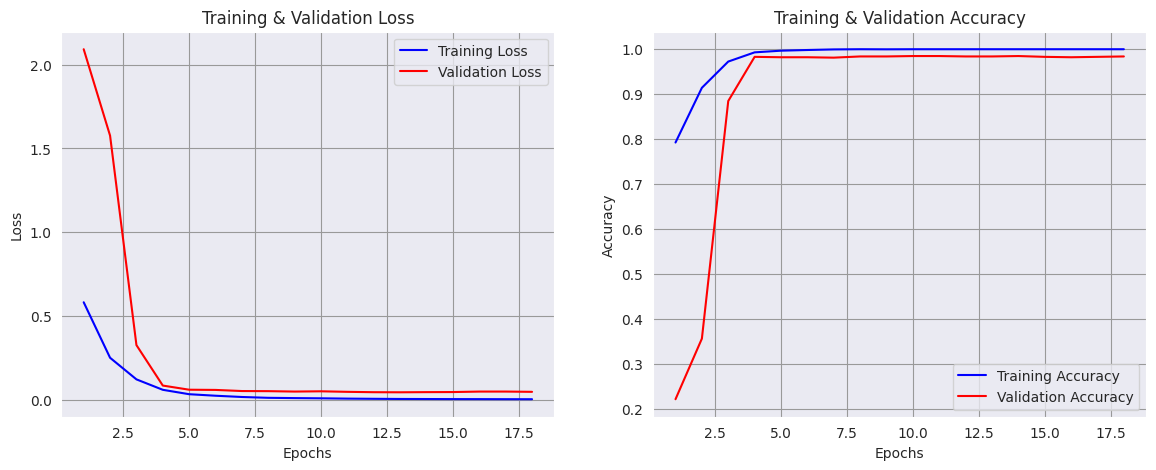

In [46]:
%matplotlib inline
plot_training_curves(history)

<div class="alert alert-info" role="alert">

- **Overfitting Concern**: The training accuracy rapidly approaches 100%, indicating that the model is quickly memorizing the training data, while validation accuracy shows signs of plateauing after a few epochs (around 98%). This gap suggests potential overfitting.
- **Early Stopping**: Early stopping was triggered at epoch 18, due to a lack of improvement in validation loss.
- **Learning Dynamics**: The model shows a very steep drop in loss early on, suggesting it is learning fast, but the validation loss stabilizes around epoch 13, indicating that further epochs are providing diminishing returns for validation generalization.
</div>

### Data Augmentation

From the above results it can be seen that the model is clearly overfitting to the given data. How we can tell is that there is a sudden 20% increase in the accuracy in only one epoch and also the validation accuracy reaches 100% very early on in the training cycle.

One way to combat this issue is to have data augmentation, this will help the model to generalize better to the data.

In [173]:
# Model compilation
model = build_model(input_shape=(128, 128, 3))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

<div class="alert alert-info" role="alert">

- Training the same model with image augmentation enabled
</div>

In [103]:
def augment_image(image):
    """Apply random brightness, contrast, flip, rotation, cropping, and noise using TensorFlow ops."""

    # Random brightness adjustment (scale factor between 0.8 and 1.2)
    brightness_factor = random.uniform(0.8, 1.2)
    image = tf.image.adjust_brightness(image, delta=brightness_factor - 1.0)

    # Random contrast adjustment (scale factor between 0.8 and 1.2)
    contrast_factor = random.uniform(0.8, 1.2)
    image = tf.image.adjust_contrast(image, contrast_factor)

    # Random horizontal flip (50% chance)
    image = tf.image.random_flip_left_right(image)

    # Random rotation (-15 to 15 degrees)
    angle = random.uniform(-15, 15)
    image = tfm.vision.augment.rotate(image, angle)

    # Random cropping (85% to 95% of original size)
    crop_ratio = random.uniform(0.85, 0.95)
    image = tf.image.resize_with_crop_or_pad(image, int(image.shape[0]*crop_ratio), int(image.shape[1]*crop_ratio))

    # Resize back to original dimensions
    image = tf.image.resize(image, (128, 128))

    # Apply random Gaussian noise (50% chance)
    if random.random() > 0.5:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=10.0)
        image = image + noise
        image = tf.clip_by_value(image, 0.0, 255.0)

    # Normalize to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image

In [110]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

def preprocess_image(image_path):
    """Load and resize image to 256x256 using TensorFlow."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.image.per_image_standardization(img)
    return img

# Processing function
def process_tf_image(image_path, label, num_classes, augment_fn=None):
    """Load, preprocess, and augment image while converting label to one-hot."""
    image = preprocess_image(image_path)

    if augment_fn and tf.random.uniform(()) < 0.4:  # Apply augmentation if provided
        image = augment_fn(image)

    label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
    return image, label

# Function to create TensorFlow dataset
def load_and_preprocess_from_df(df, num_classes, batch_size=32, augment_fn=None):
    """Create a TensorFlow dataset from a DataFrame."""
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))
    dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes, augment_fn), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [111]:
# Assuming you have a DataFrame called train_df
train_dataset, label_map = load_and_preprocess_from_df(train_df, num_classes=4, batch_size=32, augment_fn=augment_image)
# Split into training and validation sets
AUTOTUNE = tf.data.AUTOTUNE
val_size = int(0.2 * len(train_dataset))  # 20% validation size

# Shuffle and split the dataset
train_dataset = train_dataset.shuffle(buffer_size=100).skip(val_size).cache().prefetch(AUTOTUNE)
val_dataset = train_dataset.take(val_size).cache().prefetch(AUTOTUNE)

len(train_dataset), len(val_dataset)

(144, 35)

In [174]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5074 - loss: 1.1158 - val_accuracy: 0.3589 - val_loss: 1.2108
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6197 - loss: 0.8111 - val_accuracy: 0.5545 - val_loss: 0.9435
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6595 - loss: 0.7052 - val_accuracy: 0.6625 - val_loss: 0.7265
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6872 - loss: 0.6400 - val_accuracy: 0.7036 - val_loss: 0.6269
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6880 - loss: 0.6218 - val_accuracy: 0.6866 - val_loss: 0.6119
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6971 - loss: 0.5966 - val_accuracy: 0.6866 - val_loss: 0.5912
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6989 - loss: 0.5792 - val_accuracy: 0.6902 - val_loss: 0.5900
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7052 - loss: 0.5771 - val_acc

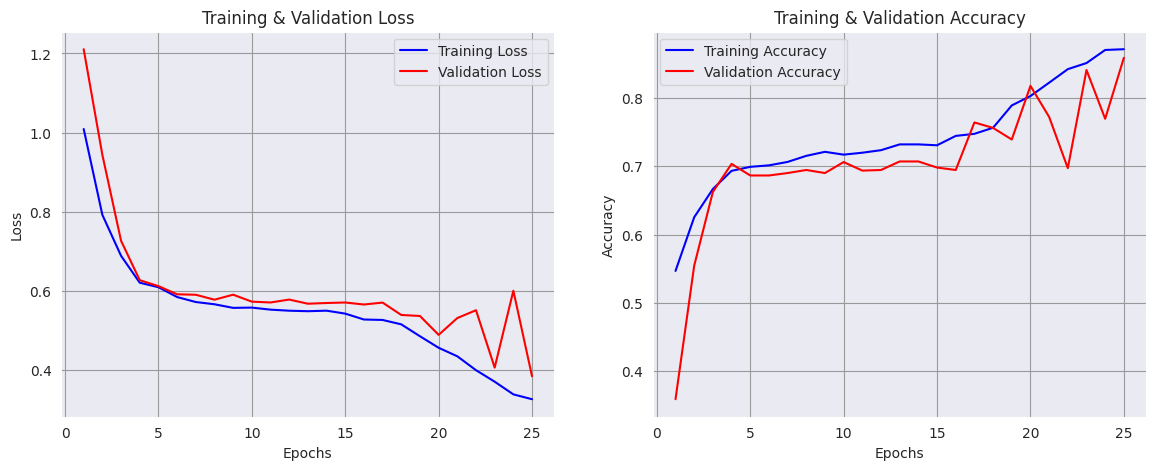

In [176]:
%matplotlib inline

plot_training_curves(history)

<div class="alert alert-info" role="alert">

- The model seems to be performing slightly better than before with no sudden performance increase
- After 20 epochs, the validation is unstable. Further tuning will be done to deal with this.
</div>

In [206]:
def build_improved_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(inputs)
    x = layers.BatchNormalization(momentum=0.90)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.90)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.90)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)  # Increased Dropout

    outputs = layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [207]:
# Model compilation
model = build_model(input_shape=(128, 128, 3))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [208]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.4093 - loss: 1.3962 - val_accuracy: 0.3938 - val_loss: 1.2440
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5608 - loss: 0.9596 - val_accuracy: 0.5223 - val_loss: 0.9981
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5982 - loss: 0.8422 - val_accuracy: 0.6205 - val_loss: 0.8102
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6380 - loss: 0.7799 - val_accuracy: 0.6500 - val_loss: 0.7310
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6435 - loss: 0.7389 - val_accuracy: 0.6643 - val_loss: 0.6973
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6713 - loss: 0.7046 - val_accuracy: 0.6705 - val_loss: 0.6760
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6831 - loss: 0.6760 - val_accuracy: 0.6839 - val_loss: 0.6559
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6827 - loss: 0.6600 - val_acc

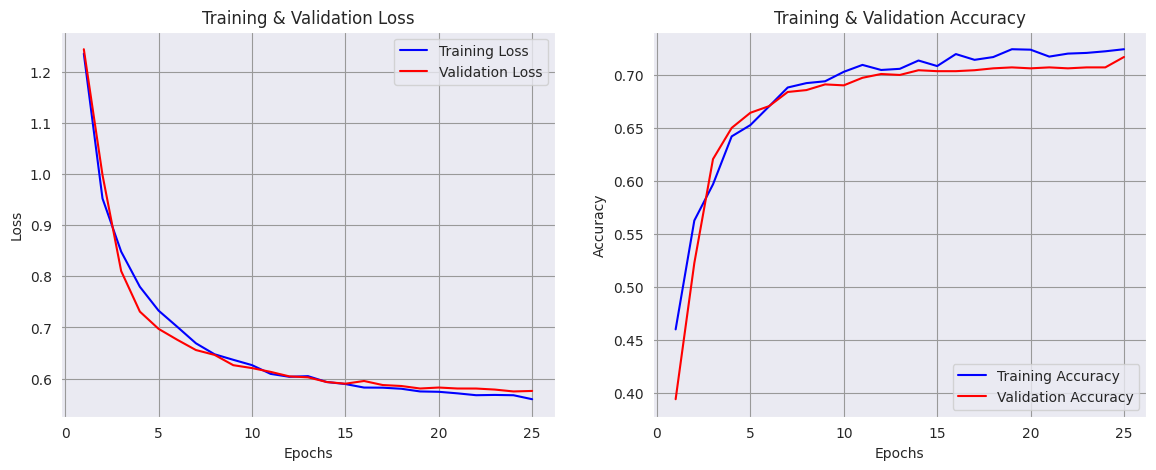

In [209]:
%matplotlib inline

plot_training_curves(history)

<div class="alert alert-info" role="alert">

- The curves are more stable now which indicates that the model is learning the data properly.
- Accuracy is around 70% for both training and validation.
- It shows that by controlling the momentum explicitly, it helps Batch Normalization adapt to the data distribution more effectively.
- A higher Dropout rate (0.5), which can reduce overfitting by preventing the model from relying too much on specific neurons.
- Lower learning rates also help the model to be more stable along with the use of AdamW optimizer
</div>

## Model Evaluation

In [202]:
test_dataset, label_map = load_and_preprocess_from_df(test_df, num_classes=4, batch_size=32, augment_fn=None)

In [203]:
label_map

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [204]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8940 - loss: 0.3398
Test Loss: 0.3348022699356079
Test Accuracy: 0.8993135094642639


Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.91      0.89       300
  meningioma       0.83      0.75      0.79       306
     notumor       0.94      0.96      0.95       405
   pituitary       0.93      0.96      0.95       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311



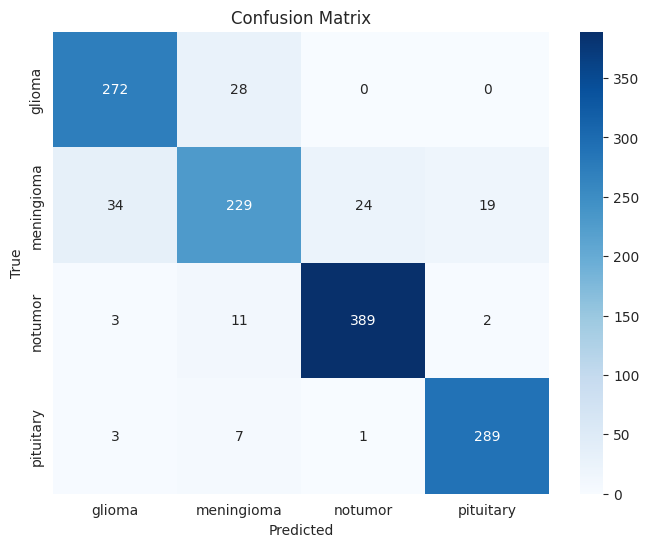

In [205]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels
    y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=1))  # Predicted labels

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Modelling (Transfer Learning on VGG16)

In [210]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

def preprocess_image(image_path):
    """Load and resize image to 256x256 using TensorFlow."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.image.per_image_standardization(img)
    return img

# Processing function
def process_tf_image(image_path, label, num_classes, augment_fn=None):
    """Load, preprocess, and augment image while converting label to one-hot."""
    image = preprocess_image(image_path)

    if augment_fn:  # Apply augmentation if provided
        image = augment_fn(image)

    label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
    return image, label

# Function to create TensorFlow dataset
def load_and_preprocess_from_df(df, num_classes, batch_size=32, augment_fn=None):
    """Create a TensorFlow dataset from a DataFrame."""
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))
    dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes, augment_fn), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [211]:
train_dataset, label_map = load_and_preprocess_from_df(train_df, num_classes=4, batch_size=32, augment_fn=None)

AUTOTUNE = tf.data.AUTOTUNE
val_size = int(0.2 * len(train_dataset))  

# Shuffle and split the dataset
train_dataset = train_dataset.shuffle(buffer_size=100).skip(val_size).cache().prefetch(AUTOTUNE)
val_dataset = train_dataset.take(val_size).cache().prefetch(AUTOTUNE)

len(train_dataset), len(val_dataset)

(144, 35)

In [212]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.applications as applications

def build_vgg16_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    base_model = applications.VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x) 
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [213]:
input_shape = (224, 224, 3)
num_classes = 4

# Build model
model = build_vgg16_model(input_shape, num_classes)

# **Use a lower learning rate initially**
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 512)                 │         262,6

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [214]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 331ms/step - accuracy: 0.6642 - loss: 1.0512 - val_accuracy: 0.8402 - val_loss: 0.4330
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.8405 - loss: 0.3969 - val_accuracy: 0.8714 - val_loss: 0.3356
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - accuracy: 0.8657 - loss: 0.3491 - val_accuracy: 0.9179 - val_loss: 0.2280
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.8862 - loss: 0.2939 - val_accuracy: 0.9179 - val_loss: 0.2242
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - accuracy: 0.8959 - loss: 0.2767 - val_accuracy: 0.9045 - val_loss: 0.2408
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.8938 - loss: 0.2753 - val_accuracy: 0.9259 - val_loss: 0.1907
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 254ms/step - accuracy: 0.9071 - loss: 0.2423 - val_accuracy: 0.9393 - val_loss: 0.1597
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - accuracy: 0.9146 - loss: 0

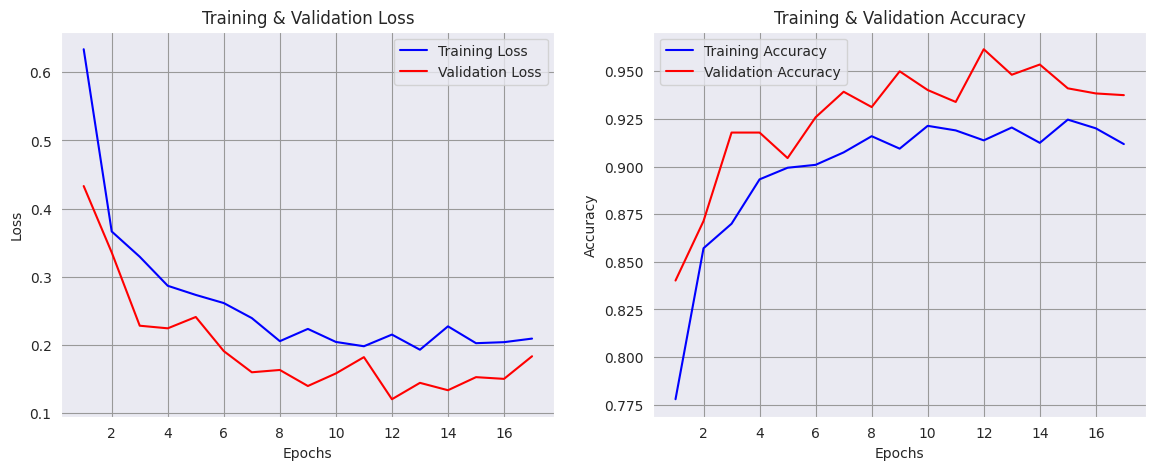

In [215]:
%matplotlib inline

plot_training_curves(history)

## Model Evaluation - Transfer Learning

In [218]:
test_dataset, label_map = load_and_preprocess_from_df(test_df, num_classes=4, batch_size=32, augment_fn=None)

In [219]:
# Assuming test_dataset is prepared and has the same preprocessing as train/val dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 513ms/step - accuracy: 0.9133 - loss: 0.2413
Test Loss: 0.24136070907115936
Test Accuracy: 0.906941294670105


Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.82      0.89       300
  meningioma       0.81      0.84      0.82       306
     notumor       0.94      0.97      0.96       405
   pituitary       0.92      0.98      0.95       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



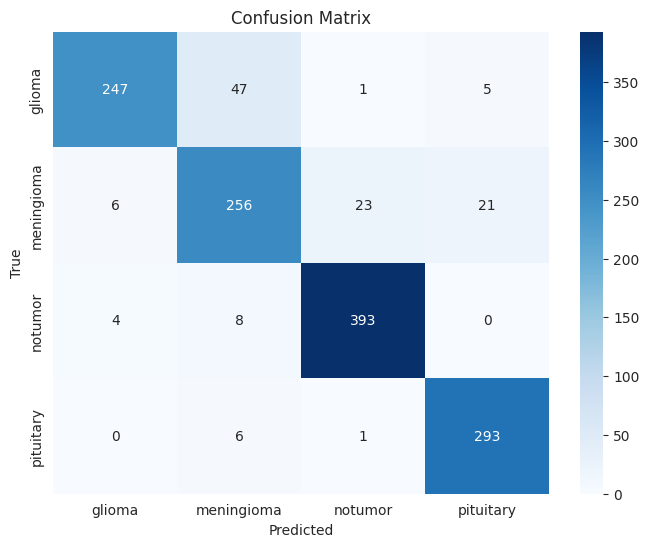

In [222]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels
    y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=1))  # Predicted labels

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Conclusion